In [28]:
import argparse
import os
from dataset.anomaly_dataset import (
    AnomalyDetecionDataset,
    load_dataset_from_path,
)
import torch
import torch.nn.functional as TF
from torch.utils.data import DataLoader
from torchvision import transforms 
from tqdm import tqdm

from resnet import wide_resnet50_2

import numpy as np

from einops import rearrange

In [29]:
def get_dataloader(data_path, gt_path):
    # set dataset transforms.
    data_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            # transforms.Normalize(mean=mean_train, std=std_train),
        ]
    )
    gt_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    train_dataset = AnomalyDetecionDataset(
        data_path,
        *load_dataset_from_path(data_path, [["good"], []], gt_path, True),
        transform=data_transforms,
        gt_transform=gt_transforms,
    )
    train_loader = DataLoader(
        train_dataset, batch_size=1, shuffle=False, num_workers=4
    )
    return train_loader

In [30]:
data_path = "/home/work/.data/dac/PN23_DAC_Silver/SI_06-231017/augmentation/train"
gt_path = "/home/work/.data/dac/PN23_DAC_Silver/SI_06-231017/augmentation/ground_truth"
ckpt = ".result/231113_triplet_semihard/models/latest.pt"
save_path = ".result/231113_triplet_semihard/result/latest"
device = 0
SAMPLING_PATCHES = 1000

In [47]:
os.makedirs(save_path, exist_ok=True)
ckpt_name = os.path.splitext(os.path.basename(ckpt))[0]
train_loader = get_dataloader(data_path, gt_path)

In [32]:
patch_size=16
ignore_neighbor=2

GI_NP = []
BI_NP = []
BI_AP = []
BI_AP_WEAK = []

GI_NP_masks = []
BI_NP_masks = []
BI_AP_masks = []
BI_AP_WEAK_masks = []
for x, gt, y, file_name in tqdm(train_loader, ncols=79, desc="Sampling"):
    patchwise_gt = (
        TF.unfold(gt, kernel_size=patch_size, stride=patch_size)
        .sum(dim=-2)
        .reshape(gt.shape[0],-1, gt.shape[-2]//patch_size, gt.shape[-1]//patch_size)
        )
    if ignore_neighbor != 0:
        normal_mask = (
            TF.max_pool2d(
                patchwise_gt,
                kernel_size=2 * ignore_neighbor + 1,
                stride=1,
                padding=ignore_neighbor
            ) == 0
        )
    else:
        normal_mask = patchwise_gt == 0

    defect_mask = patchwise_gt >= 7
    weak_defect_mask = patchwise_gt < 7
    normal_mask = rearrange(normal_mask, "b c h w -> (b h w) c").squeeze(dim=1)
    defect_mask = rearrange(defect_mask, "b c h w -> (b h w) c").squeeze(dim=1)
    weak_defect_mask = rearrange(weak_defect_mask, "b c h w -> (b h w) c").squeeze(dim=1)
    if y[0] == 0:
        GI_NP_masks.append(normal_mask.detach().cpu().numpy())
        BI_NP_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
        BI_AP_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
        BI_AP_WEAK_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
    else:
        GI_NP_masks.append(np.zeros(normal_mask.shape, dtype=np.bool_))
        BI_NP_masks.append(normal_mask.detach().cpu().numpy())
        BI_AP_masks.append(defect_mask.detach().cpu().numpy())
        BI_AP_WEAK_masks.append(weak_defect_mask.detach().cpu().numpy())


print("GI NP length :", len(GI_NP_masks))
print("BI NP length :", len(BI_NP_masks))
print("BI AP length :", len(BI_AP_masks))
print("BI AP(weak) length :", len(BI_AP_WEAK_masks))

Sampling: 100%|██████████████████████████████| 816/816 [00:28<00:00, 28.36it/s]

GI NP length : 816
BI NP length : 816
BI AP length : 816
BI AP(weak) length : 816


In [33]:


nPatches = [ m.size for m in GI_NP_masks]
masks = np.concatenate(GI_NP_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    GI_NP_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        GI_NP_masks.append(m)

nPatches = [ m.size for m in BI_NP_masks]
masks = np.concatenate(BI_NP_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    BI_NP_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        BI_NP_masks.append(m)

nPatches = [ m.size for m in BI_AP_masks]
masks = np.concatenate(BI_AP_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    BI_AP_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        BI_AP_masks.append(m)

nPatches = [ m.size for m in BI_AP_WEAK_masks]
masks = np.concatenate(BI_AP_WEAK_masks, axis=None)
if np.sum(masks != 0) > SAMPLING_PATCHES:
    idx = np.random.choice(np.where(masks != 0)[0], SAMPLING_PATCHES, replace=False)
    masks = np.zeros_like(masks)
    masks[idx] = True
    BI_AP_WEAK_masks = []
    for n in nPatches:
        m, masks = np.split(masks, [n])
        BI_AP_WEAK_masks.append(m)

print("GI NP length :", len(GI_NP_masks))
print("BI NP length :", len(BI_NP_masks))
print("BI AP length :", len(BI_AP_masks))
print("BI AP(weak) length :", len(BI_AP_WEAK_masks))

GI NP length : 816
BI NP length : 816
BI AP length : 816
BI AP(weak) length : 816


In [34]:
# from models.vae_simple import VAE
from models.triplet import TripletModel
from torchinfo import summary
device = torch.device(device)
model = TripletModel(
    in_channel=1,
    hidden_channels=[32, 64, 128],
    latent_dim=16,
    in_shape=(16, 16),
    anchor_id=0,
    margin=3
)
model.load_state_dict(torch.load(ckpt, map_location="cpu"))
model.to(device)
summary(model, (1, 1, 16, 16), col_names=['input_size', 'output_size', 'kernel_size'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape
TripletModel                             [1, 1, 16, 16]            [1, 16]                   --
├─Sequential: 1-1                        [1, 1, 16, 16]            [1, 16]                   --
│    └─ConvEocoder: 2-1                  [1, 1, 16, 16]            [1, 128, 2, 2]            --
│    │    └─Sequential: 3-1              [1, 1, 16, 16]            [1, 128, 2, 2]            --
│    └─Flatten: 2-2                      [1, 128, 2, 2]            [1, 512]                  --
│    └─Linear: 2-3                       [1, 512]                  [1, 16]                   --
│    └─Linear: 2-4                       [1, 16]                   [1, 16]                   --
Total params: 173,472
Trainable params: 173,472
Non-trainable params: 0
Total mult-adds (M): 1.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.69
Estimated Total Size (MB): 0.75

In [35]:
model.eval()
for i, (x, gt, y, file_name),  in enumerate(tqdm(train_loader, ncols=79, desc="Featuring")):
    x = x.to(device)
    with torch.no_grad():
        embedding = None
        h1 = int((x.shape[-2] - patch_size)/patch_size + 1)
        w1 = int((x.shape[-1] - patch_size)/patch_size + 1)
        patches = TF.unfold(
            x.mean(dim=1, keepdim=True),
            kernel_size=patch_size,
            stride=patch_size
        )
        patches = rearrange(
            patches,
            "b (h2 w2) (h1 w1) -> (b h1 w1) 1 h2 w2",
            h2=patch_size,
            w2=patch_size,
            h1=h1,
            w1=w1
        )

        embedding = model(patches)

    GI_NP.append(embedding[GI_NP_masks[i]].detach().cpu().numpy())
    BI_NP.append(embedding[BI_NP_masks[i]].detach().cpu().numpy())
    BI_AP.append(embedding[BI_AP_masks[i]].detach().cpu().numpy())
    BI_AP_WEAK.append(embedding[BI_AP_WEAK_masks[i]].detach().cpu().numpy())

GI_NP = np.concatenate(GI_NP, axis=0)
BI_NP = np.concatenate(BI_NP, axis=0)
BI_AP = np.concatenate(BI_AP, axis=0)
BI_AP_WEAK = np.concatenate(BI_AP_WEAK, axis=0)

Featuring: 100%|█████████████████████████████| 816/816 [00:14<00:00, 57.88it/s]


In [36]:
print("GI NP length :", len(GI_NP))
print("BI NP length :", len(BI_NP))
print("BI AP length :", len(BI_AP))
print("BI AP(weak) length :", len(BI_AP_WEAK))

GI NP length : 1000
BI NP length : 1000
BI AP length : 1000
BI AP(weak) length : 1000


In [37]:
total_features = np.concatenate([GI_NP, BI_NP, BI_AP, BI_AP_WEAK], axis=0)
label_text = ["GI_NP", "BI_NP", "BI_AP", "BI_AP_WEAK"]
label_color = ["green", "blue", "red", "orange"]
total_labels = np.concatenate([
        0*np.ones((len(GI_NP),), dtype=np.int32),
        0*np.ones((len(BI_NP),), dtype=np.int32),
        1*np.ones((len(BI_AP),), dtype=np.int32),
        2*np.ones((len(BI_AP_WEAK),), dtype=np.int32)
    ],
    axis=0
)

In [38]:
print(total_features.shape)
print(total_labels.shape)

(4000, 16)
(4000,)


In [39]:
import pickle

with open(os.path.join(save_path, "features_preproc.npy"), "wb") as f:
    pickle.dump(
        (total_features, total_labels, 2),
        f
    )

In [40]:
np.load(os.path.join(save_path, "features_preproc.npy"), allow_pickle=True)

(array([[   7.6915855,   75.62756  , -149.60619  , ..., -107.30348  ,
         -115.31359  ,  -72.15556  ],
        [ -22.433577 ,   56.514027 , -119.77618  , ..., -108.36333  ,
         -112.944374 ,  -19.870771 ],
        [ -39.58025  ,   12.050878 ,  -52.741417 , ...,  -62.483418 ,
          -67.33588  ,    5.4171453],
        ...,
        [  35.390858 ,  -61.279564 ,  120.51229  , ...,  127.62338  ,
          127.28863  ,   21.850807 ],
        [ -56.80159  ,   73.359535 , -147.81357  , ..., -159.07751  ,
         -161.04926  ,  -25.06396  ],
        [  35.59911  ,  -66.70537  ,  151.28372  , ...,  141.80621  ,
          148.3172   ,   38.10536  ]], dtype=float32),
 array([0, 0, 0, ..., 2, 2, 2], dtype=int32),
 2)

In [41]:
from sklearn.manifold import Isomap, TSNE
import pickle

transformer = Isomap(n_neighbors=10)
emb_features = transformer.fit_transform(total_features)

with open(os.path.join(save_path, "Isomap-features.pkl"), "wb") as f:
    pickle.dump(
        (emb_features, total_labels, label_text),
        f
    )


In [48]:
with open(os.path.join(save_path, "Isomap-features.pkl"), "rb") as f:
    emb_features, total_labels, label_text = pickle.load(f)


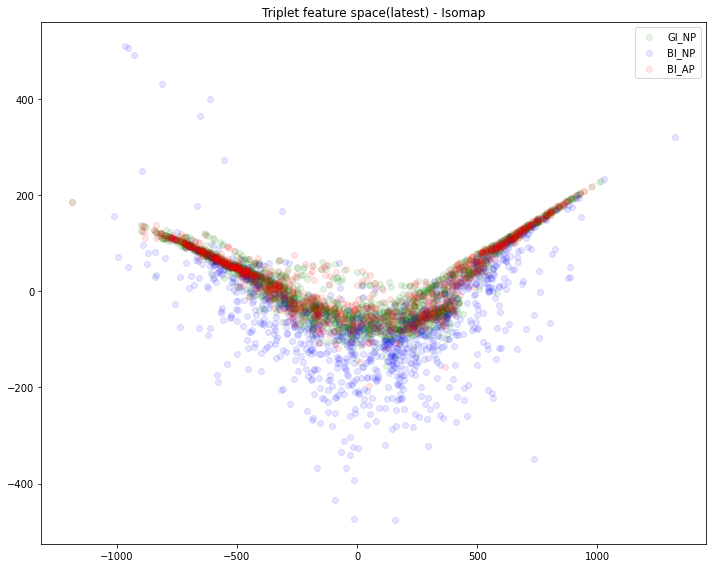

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8), facecolor="white")
for l in np.unique(total_labels):
    l = int(l.item())
    idxs = total_labels == l
    features = emb_features[idxs]
    ax.scatter(
        features[:,0],
        features[:,1],
        alpha=0.1,
        label=label_text[l],
        color=label_color[l]
    )
ax.legend()
ax.set_title(f"Triplet feature space({ckpt_name}) - Isomap")
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(save_path, "Isomap-embedding.png"))
# plt.close(fig)

In [44]:
from sklearn.manifold import Isomap, TSNE

transformer = TSNE(perplexity=30)
emb_features = transformer.fit_transform(total_features)

with open(os.path.join(save_path, "TNSE-features.pkl"), "wb") as f:
    pickle.dump(
        (emb_features, total_labels, label_text),
        f
    )


In [50]:
with open(os.path.join(save_path, "TNSE-features.pkl"), "rb") as f:
    emb_features, total_labels, label_text = pickle.load(f)


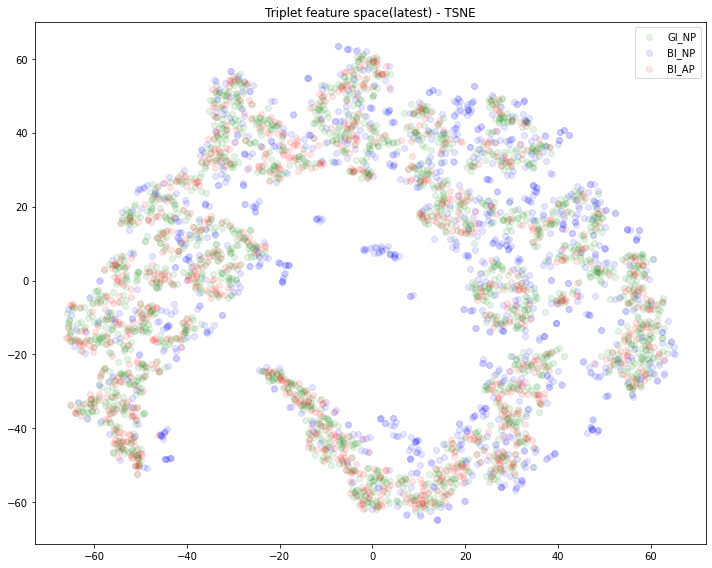

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8), facecolor="white")
for l in np.unique(total_labels):
    l = int(l.item())
    idxs = total_labels == l
    features = emb_features[idxs]
    ax.scatter(
        features[:,0],
        features[:,1],
        alpha=0.1,
        label=label_text[l],
        color=label_color[l]
    )
ax.legend()
ax.set_title(f"Triplet feature space({ckpt_name}) - TSNE")
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(save_path, "TSNE-embedding.png"))
# plt.close(fig)